In [44]:
%matplotlib inline
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
#Files located in the folder
from rebin_ndarray import bin_ndarray
from readcol import *

#Read FITS files
g130m = np.genfromtxt('Sightlines/CTS487/CTS487_spec-G130M')
g160m = np.genfromtxt('Sightlines/CTS487/CTS487_spec-G160M')

In [45]:
#Extract Wavelength, Flux and Error
w130 = g130m[:,0]
f130 = g130m[:,1]
e130 = g130m[:,2]

w160 = g160m[:,0]
f160 = g160m[:,1]
e160 = g160m[:,2]

In [46]:
def array_truncater(array):
    """In order to rebin by 5 pixels, count the length of the arrays 
    and delete data from extremeties such that the length is 5.
    
    Input: array - enter a 1-D array.
    Output: array - returns the truncated input array such that it is a multiple of 5."""
    
    count = len(array) % 5
    
    while(count != 0):
        array = np.delete(array, [0])
        count = count - 1
        
    return array

In [47]:
#Truncate the arrays so that they can be rebinned by 5 pixels
w130 = array_truncater(w130); w160 = array_truncater(w160)
f130 = array_truncater(f130); f160 = array_truncater(f160)
e130 = array_truncater(e130); e160 = array_truncater(e160)

#Produces the entire spectra
#Combine both grating
w = np.concatenate((w130,w160))
f = np.concatenate((f130,f160))
e = np.concatenate((e130,e160))

In [48]:
#Two-dimensional array consisting of the wavelength and flux
a130 = np.array([w130,f130])
a160 = np.array([w160,f160])
a = np.array([w,f])

#Rebin data by 5 px
tmp130 = bin_ndarray(a130,(2,(len(w130)/5)),'avg')
tmp160 = bin_ndarray(a160,(2,(len(w160)/5)),'avg')
tmp = bin_ndarray(a,(2,(len(w)/5)),'avg')

C:\Users\Tanveer\Documents\MMO\Research\DATA\Thesis\rebin_ndarray.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ndarray = ndarray.reshape(flattened)


In [49]:
tmp

array([[  1.13255804e+03,   1.13260784e+03,   1.13265766e+03, ...,
          1.77551422e+03,   1.77557542e+03,   1.77563664e+03],
       [  6.48720000e-01,   5.64520000e-01,   5.85140000e-01, ...,
          3.68840000e-01,   4.33340000e-01,   0.00000000e+00]])

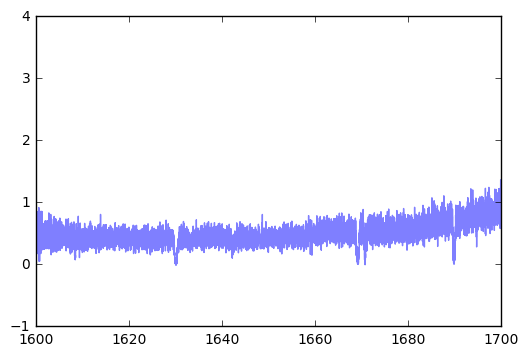

In [50]:
#Plot the entire spectra to show overlap
plt.plot(w130,f130,'r', alpha=1)
plt.plot(w160,f160,'b', alpha=0.5)
plt.axis([1600, 1700, -1, 4]) #Range of wavelength is between 1100 and 1800 angstrom. y-axis range flexible.
plt.show()

# Continuum Fitting

In [51]:
#User input variables
Sightline = 'CTS487'

#Galactic l and b
l = np.deg2rad(np.asarray(SkyCoord.from_name(Sightline).galactic.l)); b = np.deg2rad(np.asarray(SkyCoord.from_name(Sightline).galactic.l))  #In radians

#Velocity correction factors
v_corr_LSR = 9.0*np.cos(l)*np.cos(b)+12.0*np.sin(l)*np.cos(b)+7.0*np.sin(b)
#v_corr_GSR = 220.0*np.sin(l)*np.cos(b)

c=299792.458 #Speed of light in km/s

In [54]:
title = 'Al III 1670'
Lambda = 1670.7874 #From the qal.lst. Will need to automate this process
"""tmp contains the rebinned 5 px wavelength and flux arrays. Make sure that this is tmp and NOT tmp130 or tmp160, 
unless dealing with the overlap region (e.g. Si IV 1402)."""
velocity = (tmp[0]-Lambda)/Lambda*c + v_corr_LSR #Add the LSR correction factor here. Check whether this is necessary.
flux = tmp[1]

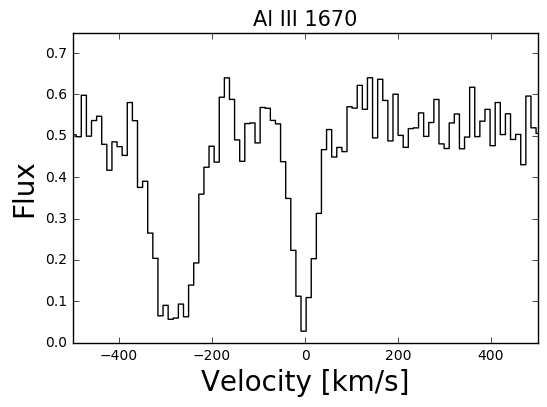

In [56]:
plt.clf()
plt.step(velocity,flux,'k')
plt.axis([-500, 500, -0,.75])
plt.xlabel('Velocity [km/s]', fontsize = 20)
plt.ylabel('Flux', fontsize = 20)
plt.title(title, fontsize = 15)
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)
#plt.savefig("Rebin2_" +Sightline+ "_" + title.replace(" ","") +".pdf", format = "pdf", bbox_inches='tight')


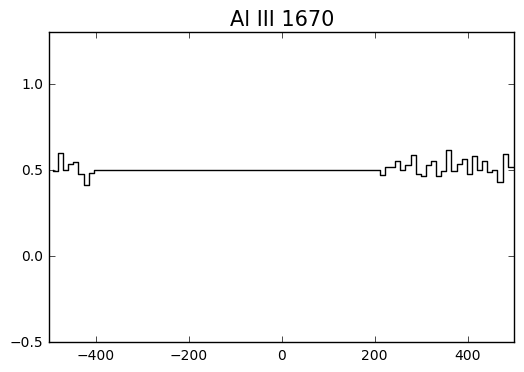

In [63]:
low1 = -500
high1 = -400
low2 = 200
high2 = 500
x1 = velocity[(velocity>=low1) & (velocity<=high1)]
x2 = velocity[(velocity>=low2) & (velocity<=high2)]
x = np.append(x1,x2)
y1 = flux[(velocity>=low1) & (velocity<=high1)]
y2 = flux[(velocity>=low2) & (velocity<=high2)]
y = np.append(y1,y2)

plt.step(x,y,'k')
plt.axis([-500, 500, -0.5, 1.3])
plt.title(title, fontsize = 15)
z = np.polyfit(x,y,1)
#print z

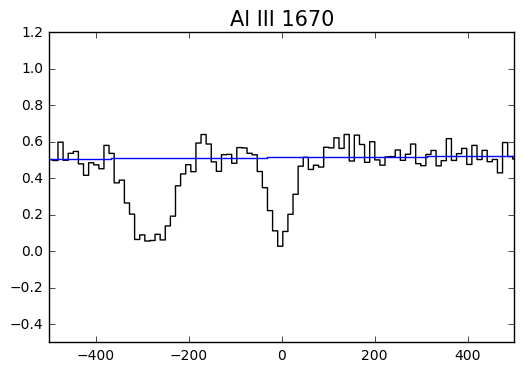

In [64]:
xp = np.linspace(-500,501,len(flux[(velocity>=-500) & (velocity<=500)]))
p = np.poly1d(z)
plt.step(velocity,flux,'k',xp,p(xp),'-')
plt.axis([-500, 500, -0.5, 1.2])
plt.title(title, fontsize = 15)

# Normalize plots

C:\Users\Tanveer\Anaconda3\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full((1, 10), 1) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


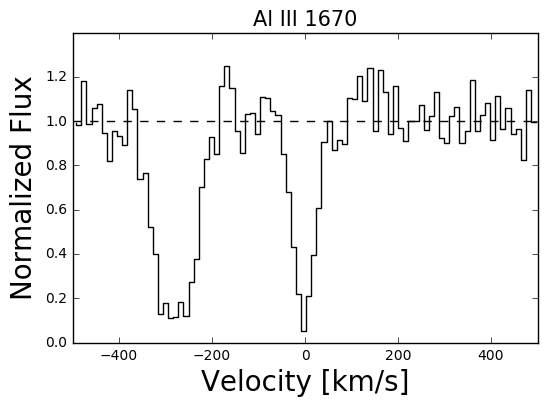

In [68]:
#Normalizing
norm_flux = flux[(velocity>=-500) & (velocity<=500)]/p(xp)

plt.clf()
tmp1 = np.linspace(-500,500,10)
tmp2 = np.full((1,10),1)[0]
plt.step(velocity[(velocity>=-500) & (velocity<=500)],norm_flux,'k')
plt.plot(tmp1,tmp2,'k--')
plt.axis([-500, 500, 0, 1.4])
plt.xlabel('Velocity [km/s]', fontsize = 20)
plt.ylabel('Normalized Flux', fontsize = 20)
plt.title(title, fontsize = 15)
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)
#plt.savefig("Normalized_" + title.replace(" ","") +".pdf", format = "pdf", bbox_inches='tight')